In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

In [2]:
torch.cuda.is_available()

False

In [46]:
Y_df, X_df, S_df = LongHorizon.load(directory="./data", group="Exchange")

In [47]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df.head()

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966


In [48]:
Y_df['unique_id'].value_counts()

unique_id
0     7588
1     7588
2     7588
3     7588
4     7588
5     7588
6     7588
OT    7588
Name: count, dtype: int64

In [49]:
n_time = len(Y_df.ds.unique())
val_size = 760
test_size = 1517

print(n_time, val_size, test_size)

Y_df.groupby('unique_id').head(2)

7588 760 1517


,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
7588,1,1990-01-01,-0.361671
7589,1,1990-01-02,-0.367639
15176,2,1990-01-01,0.735367
15177,2,1990-01-02,0.729629
22764,3,1990-01-01,-1.164373
22765,3,1990-01-02,-1.170907
30352,4,1990-01-01,2.851890
30353,4,1990-01-02,2.851890


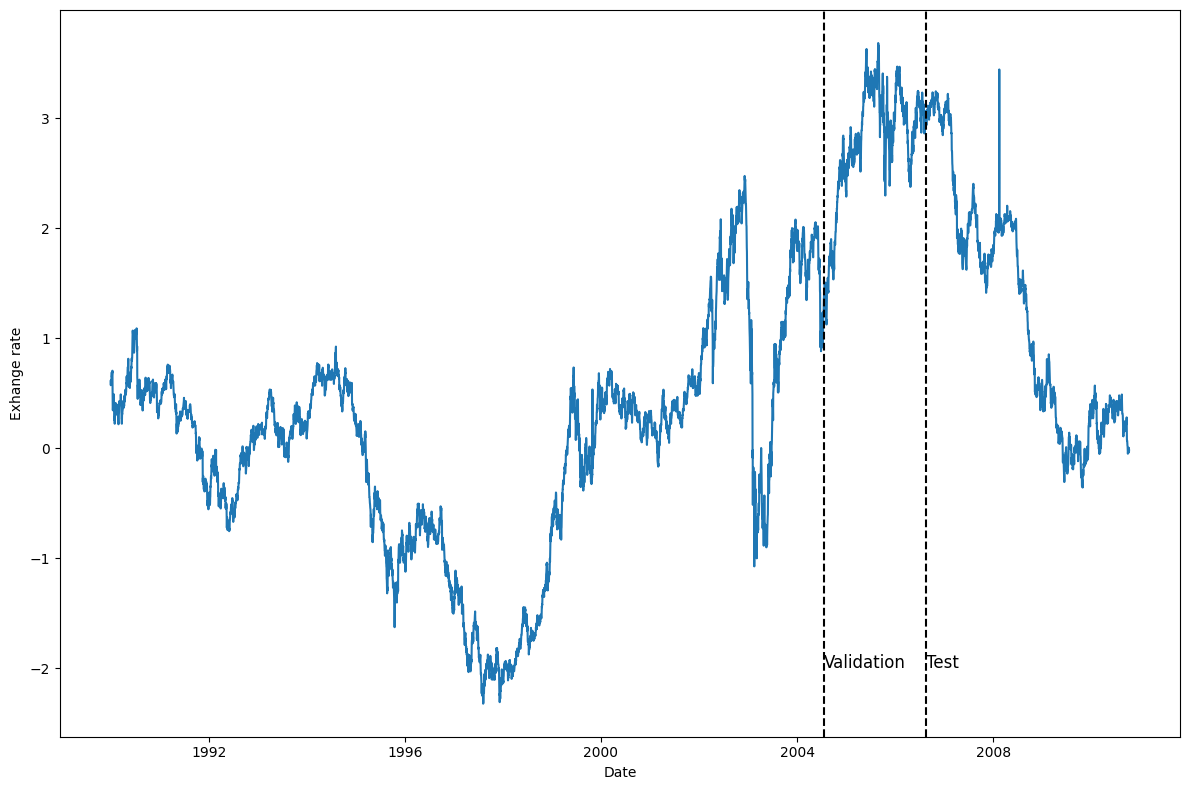

In [51]:
u_id = '0'

x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_plot

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, 'Validation', fontsize=12)
plt.text(x_test,-2, 'Test', fontsize=12)

plt.tight_layout()

In [52]:
horizon = 96

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

Global seed set to 1
Global seed set to 1
Global seed set to 1


In [53]:
nf = NeuralForecast(models=models, freq='D')

In [54]:
preds_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.03s/it]


In [55]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y
0,0,2006-08-16,2006-08-15,2.888968,2.921231,2.909362,2.948076
1,0,2006-08-17,2006-08-15,2.915061,2.895414,2.933036,3.049320
2,0,2006-08-18,2006-08-15,2.923985,2.926678,2.928148,3.064168
3,0,2006-08-19,2006-08-15,2.901915,2.892777,2.957339,3.005783
4,0,2006-08-20,2006-08-15,2.900304,2.929684,2.944296,3.010031


In [62]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values

n_series = len(Y_df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

print(y_true.shape)
print(y_pred_nhits.shape)

(8, 1422, 96)
(8, 1422, 96)


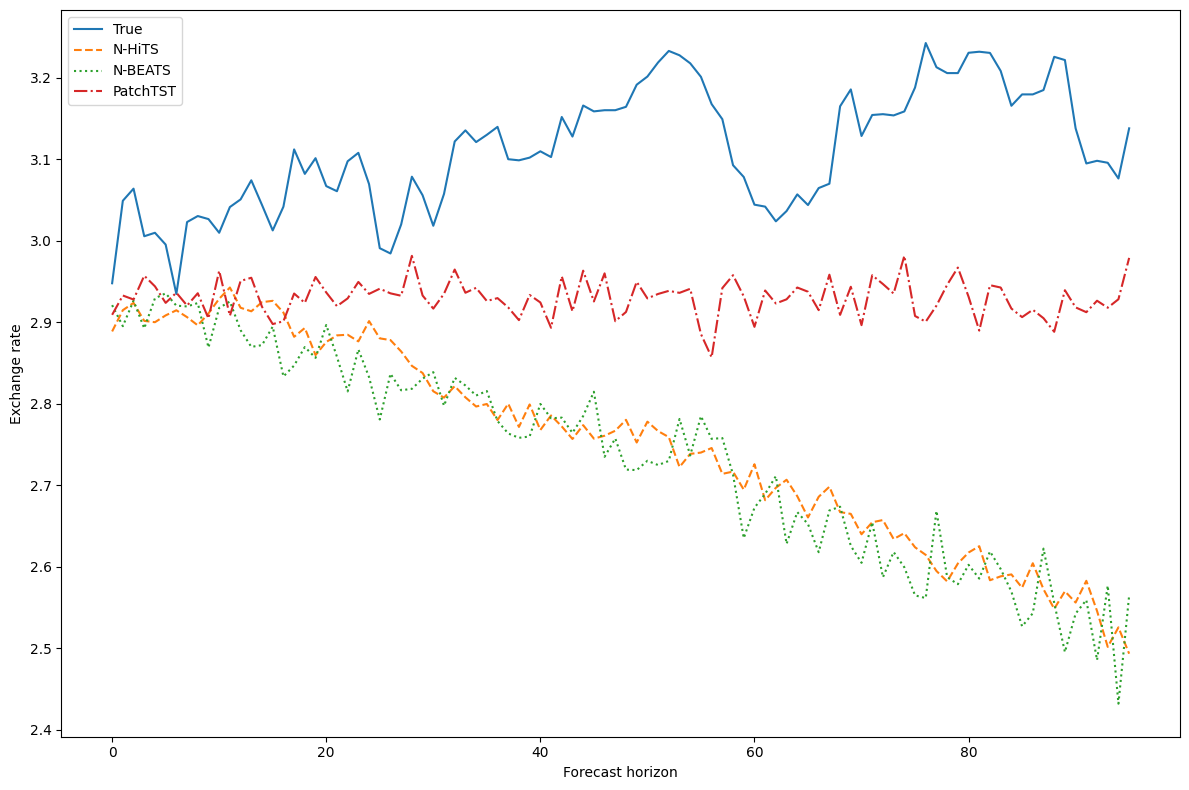

In [66]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')

plt.tight_layout()

In [70]:
data = {'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.203190,0.203990,0.198054
mse,0.082171,0.082215,0.081633
